<a href="https://colab.research.google.com/github/stefanogiagu/AI_in_MI_course_2024/blob/main/notebooks/AIinMI_2024_HandsOn_ViT_HAM10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI in Medical Image Analysis 2024
## Hands-on session on Vision Transformers

In this example we implement a Vision Transformer architecture for image classification.

**Task:** medical images (dermatoscopic images) classification


**Dataset:** <p>
The dataset is the *HAM10000 (isic2018)* ([link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)). The HAM 10000 dataset is a collection of 10015 dermatoscopic images obtained from the Medical University of Vienna, Austria, and the Cliff Rosendahl Skin Cancer Practice in Queensland Australia over the period of two years (Tschandl, Rosendahl, and Kittler 2018). Initial images from the Australia site were stored in Powerpoint files, while the Austrian images were stored as diapositives. Images were digitized with a two-fold scan, and stored as 8-bit JPEG images at 300DPI; 15x10cm. Images were then manually cropped with the lesion centered to 800x600 px at 82DPI.

The images contains representative cases of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In the HAM 10000 dataset the images are categorized in 7 classes, highly unbalanced (with one class representing about 70% of the whole dataset). After a partial rebalancing we endup with an effective dataset of 5275 images.


**Transfortmer Architecture:** <p>

We will implement the original ViT architecture: [Dosovitskiy et al., An Image Is Worth 16X16 Words: Transformers for image recongition at scale](https://arxiv.org/pdf/2010.11929.pdf), with the use of the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al. in 2020](https://arxiv.org/pdf/2002.04745.pdf).

The implementation is done using pure [PyTorch](https://pytorch.org) APIs.

For infos, latest version of the notebook, etc., contact Stefano Giagu: email: <stefano.giagu@uniroma1.it>, web: [https://www.giagu.it](https://www.giagu.it)

In [ ]:
# Download dataset

!rm -rf data
!rm -rf ISIC2018*
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
!unzip -q ISIC2018_Task3_Training_Input.zip
!unzip -q ISIC2018_Task3_Training_GroundTruth.zip

--2024-05-12 08:51:33--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.225.201, 3.5.27.45, 52.217.68.228, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.225.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘ISIC2018_Task3_Training_Input.zip’

ISIC2018_Task3_Trai 100%[===================>]   2.58G  84.4MB/s    in 31s     

2024-05-12 08:52:04 (85.5 MB/s) - ‘ISIC2018_Task3_Training_Input.zip’ saved [2771732744/2771732744]

--2024-05-12 08:52:04--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.28.229, 54.231.166.105, 3.5.9.13, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challeng

In [ ]:
# rebalance and organize the images in a folder structure suitable to be read with the torchvision.datasets.ImageFolder api

import numpy as np
import pandas as pd

df = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
labels = df.to_numpy()

import os
import shutil

for i in range(7):
  os.makedirs('/content/data/'+str(i))


# to balance classes
cfrac = [0.1111333 , 0.66949576, 0.05132302, 0.03265102, 0.1097354 , 0.01148278, 0.01417873]

for i in range(labels.shape[0]):
  lab = np.argmax(labels[i,1:])

  rnd = np.random.rand()
  if rnd >= cfrac[lab]:
    shutil.copyfile('/content/ISIC2018_Task3_Training_Input/'+labels[i,0]+'.jpg', '/content/data/'+str(lab)+'/'+labels[i,0]+'.jpg')

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

2.2.1+cu121
0.17.1+cu121


In [ ]:
# read data with torchvision

from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
import PIL


data_dir = 'data'

train_transforms = Compose([Resize((200,200)), #we downsampling images to 200x200 pc to simplify task and reduce training time
                            ToTensor()         #converte to torch tensors and normalize images
                           ])



# torchvision.datasets.ImageFolder function allows to read a dataset from a folder structure and associate to events labels on the base of the
# subfolders' name containing the images
# see https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

print(dataset)

# split dataset in training, validation and test 90:5:5 %
ev_train = int(len(dataset)*0.9)
ev_vali  = int(0.5*(len(dataset)-ev_train))
ev_test  = len(dataset) - ev_train - ev_vali
train_data, vali_data, test_data = torch.utils.data.random_split(dataset, [ev_train, ev_vali, ev_test])

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

Dataset ImageFolder
    Number of datapoints: 5314
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Trainign set size:  4782
Validation set size:  266
Test set size:  266


In [ ]:
NUM_IMAGES = 4
images = torch.stack([vali_data[idx][0] for idx in range(NUM_IMAGES)], dim=0)

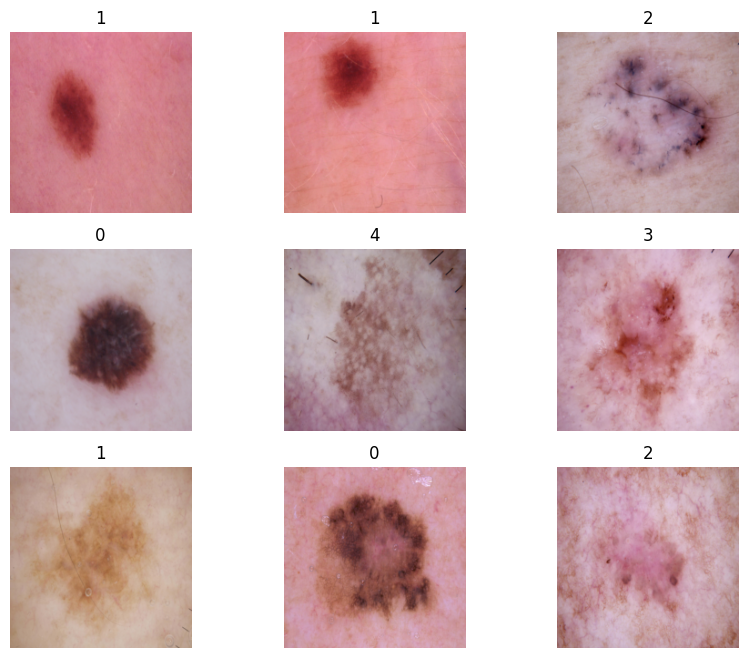

In [ ]:
# example of some of the images in the dataset

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #note: imshow expect image shape as (h,w,channel) while torch uses (channel,h,w)
plt.show()

In [ ]:
# plot label frequencies in the dataset
label = train_data.dataset.targets

(array([0.18630034, 0.43394806, 0.09108017, 0.05946556, 0.18103124,
        0.02145277, 0.02672187]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

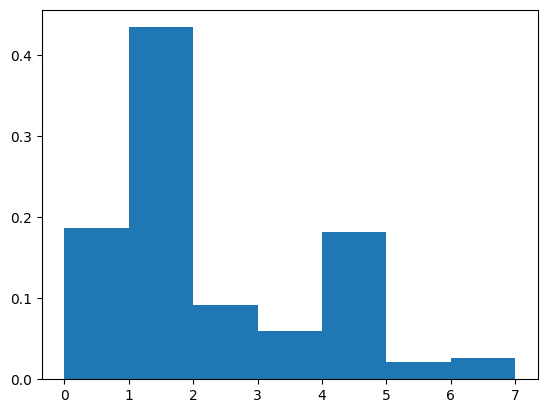

In [ ]:
plt.hist(label, bins=7, range=[0,7], density=True)

In [ ]:
# check GPU
if torch.cuda.is_available():
  print('Number of availabel GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Number of availabel GPUs:  1
Tesla T4
Computation device: cuda



# ViT architecture

Transformers have been originally proposed to process sets (un-ordered lists of items) since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted.

To apply Transformers to sequences (ordered lists), we need to add a positional encoding to the input feature vectors. Hopefully the model will learn by itself how to use this additional information.

In this session we will work with images following the procedure proposed by Dosovitskiy et al.  in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale".

Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches.

As a preprocessing step, we need to divide the image in a sequence of small patches.

Each of those patches is considered to be a "word"/"token" and projected to a feature space.

Then we will add a spatial encoding (additional paramenters that will encode the position of each patch in the larger image) to each patch. After this preprocessing we can apply a Transformer as usual to this sequence and start training it for our task.

Transformers can work with high resolution images and learn how to use context from very distant portion of the image.

We'll use 100 patches of 20x20 pixels, this is not an optmize value, so most probably a different choice may provide better perfromance ...

In [ ]:
# function to divide the input batch of images in a sequence of small patches

def img_to_patch(x, patch_size, flatten_channels=True):
    # flatten channels is more important as a parameter if we are working with multi channel images
    """
    Inputs:
        x - torch.Tensor representing the batch of images of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid. This is more important when working with
                           multi channel images
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

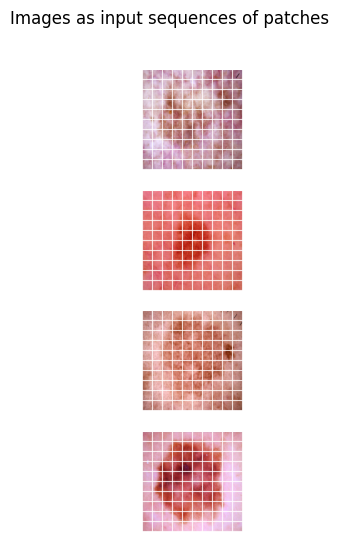

In [ ]:
img_patches = img_to_patch(images, patch_size=20, flatten_channels=False)

fig, ax = plt.subplots(images.shape[0], 1, figsize=(18,6))
fig.suptitle("Images as input sequences of patches")
for i in range(images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=10, normalize=True, pad_value=1)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

compared to the original images, it is much harder to recognize the objects from each single patch. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model.

We use the Pre-Layer Normalization version of the Transformer blocks proposed by Ruibin Xiong et al. in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage.

In [ ]:
class AttentionBlock(nn.Module):
    #  Implements the standard attention (multi-head attention + MLP) block for
    #  a tranformer encoder architecture

    #  structure:
    #   MHA: pre layer normalization (see Ruibin Xiong et al. (2020)) + multi-head attention (pytorch implementation) + layer normalization
    #   MLP: dense + gelu + droput + dense + dropout

    #  arguments:
    #   embed_dim  - Dimensionality of input and attention feature vectors
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network
    #                (usually 2-4x larger than embed_dim)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   dropout    - Amount of dropout to apply in the feed-forward network

    #    ^
    #    |_____    NOR2(x) + NOR2(MHA(NOR1(x))) + MLP(NOR2(MHA(NOR1(x)))): output (L,B,embde_dim)
    #    |     ^
    #  -----   |
    # | MLP |  |
    #  -----   |
    #    |_____|
    #    |
    #  -----
    # | NOR |
    #  -----
    #    |_____    x + MHA(NOR1(x))
    #    |     ^
    #  -----   |
    # | MHA |  |
    #  -----   |
    #    |     |
    #  -----   |
    # | NOR |  |
    #  -----   |
    #    |_____|
    #    |        x

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super(AttentionBlock, self).__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads) #this pytorch function implements a full MH-Attention block (see https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0] #nn.MultiheadAttention expects input shapes 3x(L,B,F) and output
        x = self.layer_norm_2(x)
        x = x + self.mlp(x)
        return x

Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

- A linear projection layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each patch independently as input.

- A classification token that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.

- Learnable positional encodings that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions [Here you can find a good explanation of positional encodings for NLP sequences with varing length](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

- An MLP head that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.


Vision Transformer Architecture:


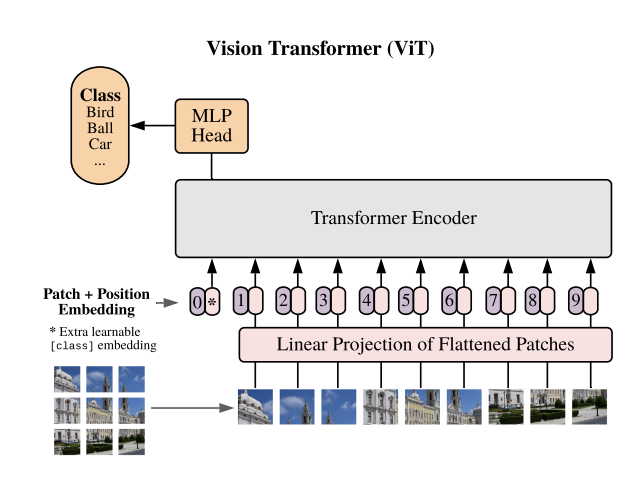

In [ ]:
from IPython.display import Image
Image('http://giagu.web.cern.ch/giagu/CERN/ViT.png', width=500)

In [ ]:
class VisionTransformer(nn.Module):
    #  Classifier based on a ViT  architecture implementation
    #  arguments:
    #   embed_dim  - Dimensionality of embedding in input fetaure vector to the Transformer
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network
    #   num_channels - Number of channels of the input (3 for RGB)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   num_layers - Number of layers to use in the Transformer
    #   patch_size - Number of pixels that the patches have per dimension
    #   num_patches - Maximum number of patches an image can have
    #   num_classes- Number of categories for the classification task
    #   dropout    - Amount of dropout to apply in the feed-forward network and in the input

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, patch_size, num_patches, num_classes, dropout=0.0):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size

        # input layer (a dense layer projecting the input in a embed_dim embedding space)
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)

        # Transformer encoder: stack of num_layers Attention Blocks (embed_dim -> embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])

        # MLP Classifier (embed_dim -> num_classes)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)


        #parameters / embedding
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))# this is our positional  embedding. It is initialized as a random number but it is learnable so it will be optimized during training.


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
# instantiation of a new model

# NOTE: embed_dim MUST be an integer multiple of num_heads
model_kwargs={
              'embed_dim': 64,
              'hidden_dim': 128,
              'num_heads': 8,
              'num_layers': 4,
              'patch_size': 20,
              'num_channels': 3,
              'num_patches': 100,
              'num_classes': 7,
              'dropout': 0.30
             }

model = VisionTransformer(**model_kwargs)

In [ ]:
# print the model structure

print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(3,200,200))
else:
  summary(model, input_size=(3,200,200))

VisionTransformer(
  (input_layer): Linear(in_features=1200, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,),

In [ ]:
# test the model on one batch to check everything is ok before training it

model.to(device) #move the model on device (cpu/gpu)

xb,yb=next(iter(train_loader)) #take a mini batch from the trainign dataloader
xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
yb=yb.type(torch.long).to(device)
print(xb.shape)
print(yb.shape)

out=model(xb) #apply the model on the input batch
print(out.shape)

torch.Size([256, 3, 200, 200])
torch.Size([256])
torch.Size([256, 7])


## Training Procedure

We are now ready to complete the model by defining the loss function, the accuracy metric to monitor the training of the classifier, and the optmizer + learning rate scheduler.

Write two simple procedures to train and test the model on the training and test dataset, respectively.

If you are not new to PyTorch, this scheme should appear familiar to you. Otherwise, the PyTorch web site provides [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics]
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
#loss
loss_func = nn.CrossEntropyLoss() #cross entropy loss

#metric accuracy from torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
metric_func = MulticlassAccuracy(num_classes=7)
metric_func = metric_func.to(device)

# optimizer: we'll use AdamW eg Adam with a better weight decay (eg L2 regularisation) that provides better generalisation performance
from torch import optim
#opt = optim.Adam(model.parameters(), lr=1e-3)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0001)

# scheduler for step decay lr schedule
#lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,30,35], gamma=0.2)

In [ ]:
#Checkpoints (to save model parameters during training)

# this is implemented by writing a python class that uses the torch.save method

class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [ ]:
# in pytorch you are responsible of writing the training loop, this can be done by implementig specific
# python functions for the training and validation steps, or just, like in this example, by using a simple plain
# python loop

#training loop

epochs = 100 #number of epochs

import time

save_best_model = SaveBestModel() #initialize checkpoint function

# dfine python lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in train_loader: #takes a batch from the train dataloader
        counter += 1
        xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
        yb=yb.type(torch.long).to(device)

        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        #print(pred.shape)
        #print(yb.shape)
        metric = metric_func(pred, yb) #compute accuracy

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/(counter)
    train_metric = train_metric/(counter)

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # evaluation step (same as training but w/o backpropagation)

    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.long).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)

        vali_loss += vloss.item()
        vali_metric += vmetric.item()

    vali_loss = vali_loss/(counter)
    vali_metric = vali_metric/(counter)

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)

    elapsed_time = time.time()-t0
    #current_lr = lr_scheduler.get_last_lr()[0]
    #print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))
    print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    #lr_scheduler.step()


Best validation loss: 1.5775576829910278

Saving best model for epoch: 1

epoch: 1, time(s): 59.16, train loss: 1.606557, train metric: 0.141891, vali loss: 1.577558, vali metric: 0.142857

Best validation loss: 1.5630866289138794

Saving best model for epoch: 2

epoch: 2, time(s): 43.24, train loss: 1.568552, train metric: 0.144180, vali loss: 1.563087, vali metric: 0.142857

Best validation loss: 1.5511705875396729

Saving best model for epoch: 3

epoch: 3, time(s): 47.41, train loss: 1.559736, train metric: 0.142857, vali loss: 1.551171, vali metric: 0.142857

Best validation loss: 1.5414845943450928

Saving best model for epoch: 4

epoch: 4, time(s): 44.00, train loss: 1.558388, train metric: 0.142857, vali loss: 1.541485, vali metric: 0.142857

Best validation loss: 1.5169713497161865

Saving best model for epoch: 5

epoch: 5, time(s): 42.08, train loss: 1.539697, train metric: 0.144174, vali loss: 1.516971, vali metric: 0.142857

Best validation loss: 1.4554988145828247

Saving 

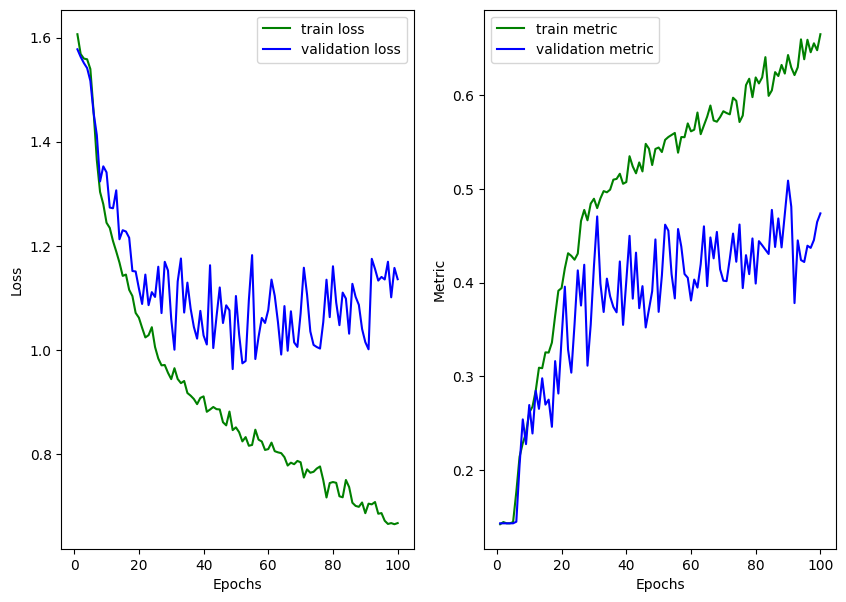

In [ ]:
# plot training results (loss and accuracy vs epoch)

plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [ ]:
# load the best model
checkpoint = torch.load('./best_model.pth')
print('Best model at epoch: ', checkpoint['epoch'])

model = VisionTransformer(**model_kwargs)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Best model at epoch:  49


VisionTransformer(
  (input_layer): Linear(in_features=1200, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,),

In [ ]:
# inference on test set
pred_prob = torch.empty(size=(0,7), device=device) #note the device parameter, this allows to create the torch tensors directly in the needed device
pred_val = torch.empty(size=(0,), device=device)
ground_truth = torch.empty(size=(0,), device=device)

model.to(device)

test_loss = 0.0
test_metric = 0.0

counter=0
with torch.no_grad():
  for xb, yb in test_loader:
    counter += 1
    xb=xb.type(torch.float).to(device)
    yb=yb.type(torch.long).to(device)
    res = model(xb)
    pre = torch.softmax(res, dim=1)
    val = pre.argmax(dim=1)
    pred_prob = torch.cat((pred_prob, pre), dim=0)
    pred_val = torch.cat((pred_val, val), dim=0)
    ground_truth = torch.cat((ground_truth, yb), dim=0)
    vloss = loss_func(res, yb)
    vmetric = metric_func(res, yb)
    test_loss += vloss.item()
    test_metric += vmetric.item()

test_loss = test_loss/(counter)
test_metric = test_metric/(counter)

predict_val = pred_val.cpu().data.numpy()
predict_prob = pred_prob.cpu().data.numpy()
true_val = ground_truth.cpu().data.numpy()

print('test loss: ', test_loss)
print('test average accuracy: ', test_metric)

test loss:  1.0346635580062866
test average accuracy:  0.419569194316864


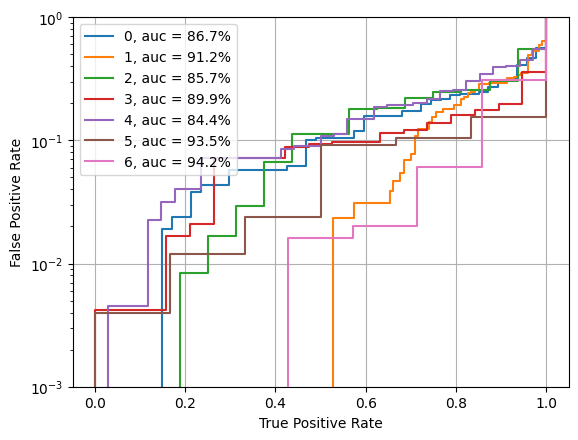

In [ ]:
from sklearn.metrics import roc_curve, auc

# print ROC curves
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(range(7)): #7 classes
        fpr[label], tpr[label], threshold = roc_curve((true_val==i), predict_prob[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [ ]:
#function to print a formatted confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:
# confusion matrix

mylabels = [str(i) for i in list(range(7))]

from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(true_val, predict_val, normalize='true')
print("Confusion Matrix:")
print("")
print_cm(c_mat,mylabels)

Confusion Matrix:

              0     1     2     3     4     5     6 
        0  0.60  0.06  0.04  0.00  0.30  0.00  0.00 
        1  0.13  0.70  0.00  0.00  0.17  0.00  0.00 
        2  0.12  0.06  0.31  0.00  0.50  0.00  0.00 
        3  0.21  0.00  0.05  0.11  0.63  0.00  0.00 
        4  0.12  0.09  0.00  0.00  0.79  0.00  0.00 
        5  0.17  0.00  0.17  0.33  0.33  0.00  0.00 
        6  0.00  0.14  0.29  0.00  0.14  0.00  0.43 


**NOTE:** much better perfromance can be obtained by:
1. use larger size images (eg reduce the downsizing)
2. pretrain the visual transformer on a larger dataset (imagenet), then fine tune to the HAM10000 dataset
3. tune the model hyperparameters (batch size, learning rate and weight decays, number of patches/patch size, dimension